In [ ]:
import os
import openai
import sys
sys.path.append('..')

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

In [ ]:
# stuff
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.schema import StrOutputParser
from langchain.schema.prompt_template import format_document

# map reduce
from functools import partial

from langchain.chains.combine_documents import collapse_docs, split_list_of_docs
from langchain.schema.runnable import RunnableParallel, RunnablePassthrough

# refine
from operator import itemgetter
from langchain.callbacks.manager import trace_as_chain_group


In [ ]:
llm = ChatOpenAI()

# Prompt and method for converting Document -> str.
document_prompt = PromptTemplate.from_template("{page_content}")
summarize_prompt = PromptTemplate.from_template("Summarize the following content:\n\n{context}")
partial_format_document = partial(format_document, prompt=document_prompt)

In [ ]:
from langchain.schema import Document

text = """Nuclear power in space is the use of nuclear power in outer space, typically either small fission systems or radioactive decay for electricity or heat. Another use is for scientific observation, as in a Mössbauer spectrometer. The most common type is a radioisotope thermoelectric generator, which has been used on many space probes and on crewed lunar missions. Small fission reactors for Earth observation satellites, such as the TOPAZ nuclear reactor, have also been flown.[1] A radioisotope heater unit is powered by radioactive decay and can keep components from becoming too cold to function, potentially over a span of decades.[2]

The United States tested the SNAP-10A nuclear reactor in space for 43 days in 1965,[3] with the next test of a nuclear reactor power system intended for space use occurring on 13 September 2012 with the Demonstration Using Flattop Fission (DUFF) test of the Kilopower reactor.[4]

After a ground-based test of the experimental 1965 Romashka reactor, which used uranium and direct thermoelectric conversion to electricity,[5] the USSR sent about 40 nuclear-electric satellites into space, mostly powered by the BES-5 reactor. The more powerful TOPAZ-II reactor produced 10 kilowatts of electricity.[3]

Examples of concepts that use nuclear power for space propulsion systems include the nuclear electric rocket (nuclear powered ion thruster(s)), the radioisotope rocket, and radioisotope electric propulsion (REP).[6] One of the more explored concepts is the nuclear thermal rocket, which was ground tested in the NERVA program. Nuclear pulse propulsion was the subject of Project Orion.[7]

Regulation and hazard prevention[edit]
After the ban of nuclear weapons in space by the Outer Space Treaty in 1967, nuclear power has been discussed at least since 1972 as a sensitive issue by states.[8] Particularly its potential hazards to Earth's environment and thus also humans has prompted states to adopt in the U.N. General Assembly the Principles Relevant to the Use of Nuclear Power Sources in Outer Space (1992), particularly introducing safety principles for launches and to manage their traffic.[8]

Benefits

Both the Viking 1 and Viking 2 landers used RTGs for power on the surface of Mars. (Viking launch vehicle pictured)
While solar power is much more commonly used, nuclear power can offer advantages in some areas. Solar cells, although efficient, can only supply energy to spacecraft in orbits where the solar flux is sufficiently high, such as low Earth orbit and interplanetary destinations close enough to the Sun. Unlike solar cells, nuclear power systems function independently of sunlight, which is necessary for deep space exploration. Nuclear-based systems can have less mass than solar cells of equivalent power, allowing more compact spacecraft that are easier to orient and direct in space. In the case of crewed spaceflight, nuclear power concepts that can power both life support and propulsion systems may reduce both cost and flight time.[9]

Selected applications and/or technologies for space include:

Radioisotope thermoelectric generator
Radioisotope heater unit
Radioisotope piezoelectric generator
Radioisotope rocket
Nuclear thermal rocket
Nuclear pulse propulsion
Nuclear electric rocket
"""

docs = [
    Document(
        page_content=split,
        metadata={"source": "https://en.wikipedia.org/wiki/Nuclear_power_in_space"},
    )
    for split in text.split("\n\n")
]

In [ ]:
docs[0]

## Stuff

The stuff documents chain (“stuff” as in “to stuff” or “to fill”) is the most straightforward of the document chains. It takes a list of documents, inserts them all into a prompt and passes that prompt to an LLM.

This chain is well-suited for applications where documents are small and only a few are passed in for most calls.

### Recreating with LCEL
With LangChain Expression Language we can easily recreate the StuffDocumentsChain functionality, with the additional benefit of getting all the built-in LCEL features (batch, async, etc.) and with much more ability to customize specific parts of the chain.

In [ ]:
chain = (
    {
        "context": lambda docs: "\n\n".join(
            format_document(doc, document_prompt) for doc in docs
        )
    }
    | summarize_prompt
    | ChatOpenAI()
    | StrOutputParser()
)

### Stuff Example Run

In [ ]:
print(chain.invoke(docs))

## Map Reduce

The map reduce documents chain first applies an LLM chain to each document individually (the Map step), treating the chain output as a new document. It then passes all the new documents to a separate combine documents chain to get a single output (the Reduce step). It can optionally first compress, or collapse, the mapped documents to make sure that they fit in the combine documents chain (which will often pass them to an LLM). This compression step is performed recursively if necessary.

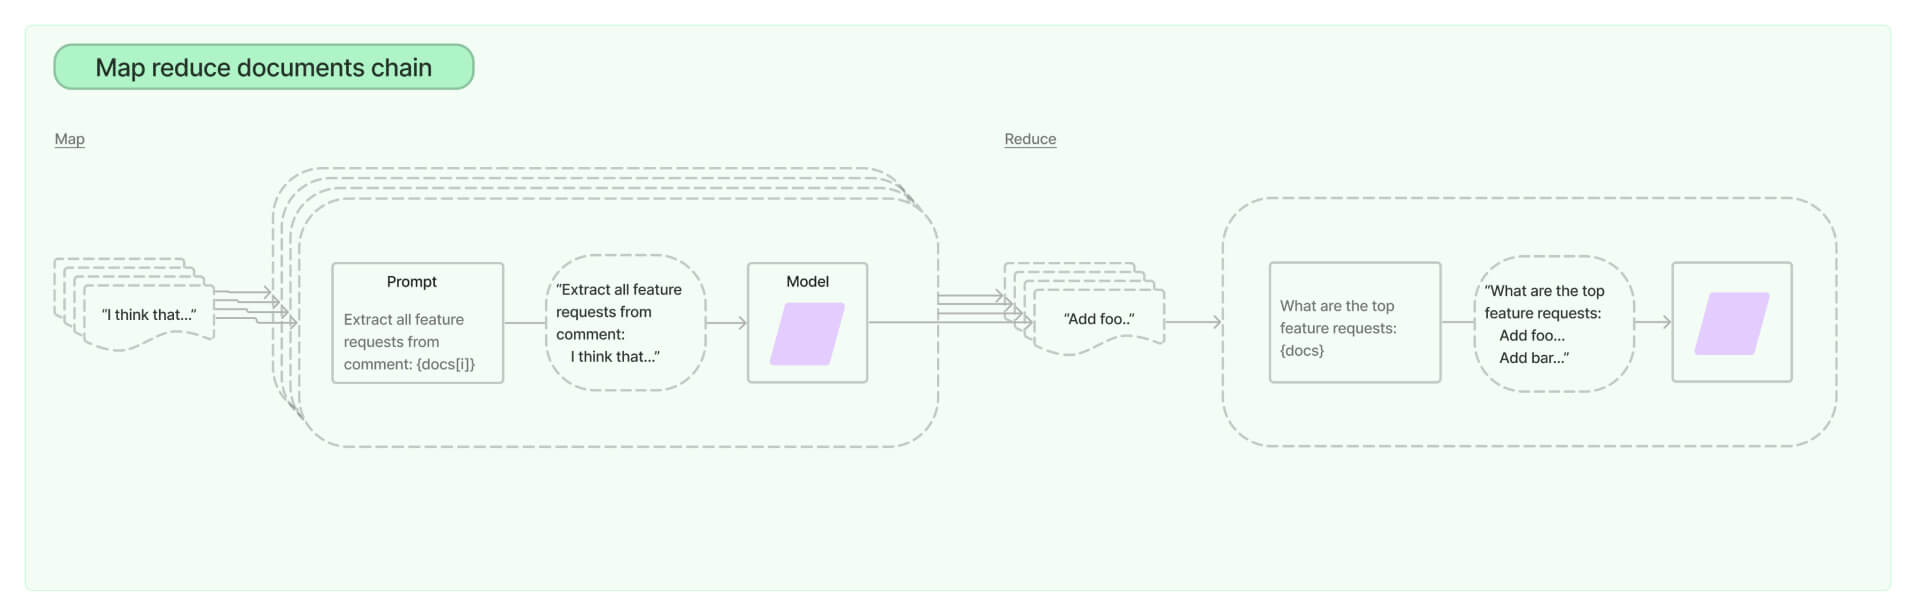

#### Legacy Map Reduce

### With LCEL

In [ ]:
# The chain we'll apply to each individual document.
# Returns a summary of the document.
map_chain = (
    {"context": partial_format_document}
    | summarize_prompt
    | llm
    | StrOutputParser()
)

# A wrapper chain to keep the original Document metadata
map_as_doc_chain = (
    RunnableParallel({"doc": RunnablePassthrough(), "content": map_chain})
    | (lambda x: Document(page_content=x["content"], metadata=x["doc"].metadata))
).with_config(run_name="Summarize (return doc)")

In [ ]:
# The chain we'll repeatedly apply to collapse subsets of the documents
# into a consolidate document until the total token size of our
# documents is below some max size.
def format_docs(docs):
    return "\n\n".join(partial_format_document(doc) for doc in docs)


collapse_chain = (
    {"context": format_docs}
    | PromptTemplate.from_template("Collapse this content:\n\n{context}")
    | llm
    | StrOutputParser()
)


def get_num_tokens(docs):
    return llm.get_num_tokens(format_docs(docs))


def collapse(
    docs,
    config,
    token_max=4000,
):
    collapse_ct = 1
    while get_num_tokens(docs) > token_max:
        config["run_name"] = f"Collapse {collapse_ct}"
        invoke = partial(collapse_chain.invoke, config=config)
        split_docs = split_list_of_docs(docs, get_num_tokens, token_max)
        docs = [collapse_docs(_docs, invoke) for _docs in split_docs]
        collapse_ct += 1
    return docs

In [ ]:
# The chain we'll use to combine our individual document summaries
# (or summaries over subset of documents if we had to collapse the map results)
# into a final summary.

reduce_chain = (
    {"context": format_docs}
    | PromptTemplate.from_template("Combine these summaries:\n\n{context}")
    | llm
    | StrOutputParser()
).with_config(run_name="Reduce")

In [ ]:
# The final full chain
map_reduce = (map_as_doc_chain.map() | collapse | reduce_chain).with_config(
    run_name="Map reduce"
)

## Map Reduce Example Run

In [ ]:
print(map_reduce.invoke(docs[0:1], config={"max_concurrency": 5}))

## Refine

The Refine documents chain constructs a response by looping over the input documents and iteratively updating its answer. For each document, it passes all non-document inputs, the current document, and the latest intermediate answer to an LLM chain to get a new answer.

Since the Refine chain only passes a single document to the LLM at a time, it is well-suited for tasks that require analyzing more documents than can fit in the model’s context. The obvious tradeoff is that this chain will make far more LLM calls than, for example, the Stuff documents chain. There are also certain tasks which are difficult to accomplish iteratively. For example, the Refine chain can perform poorly when documents frequently cross-reference one another or when a task requires detailed information from many documents.



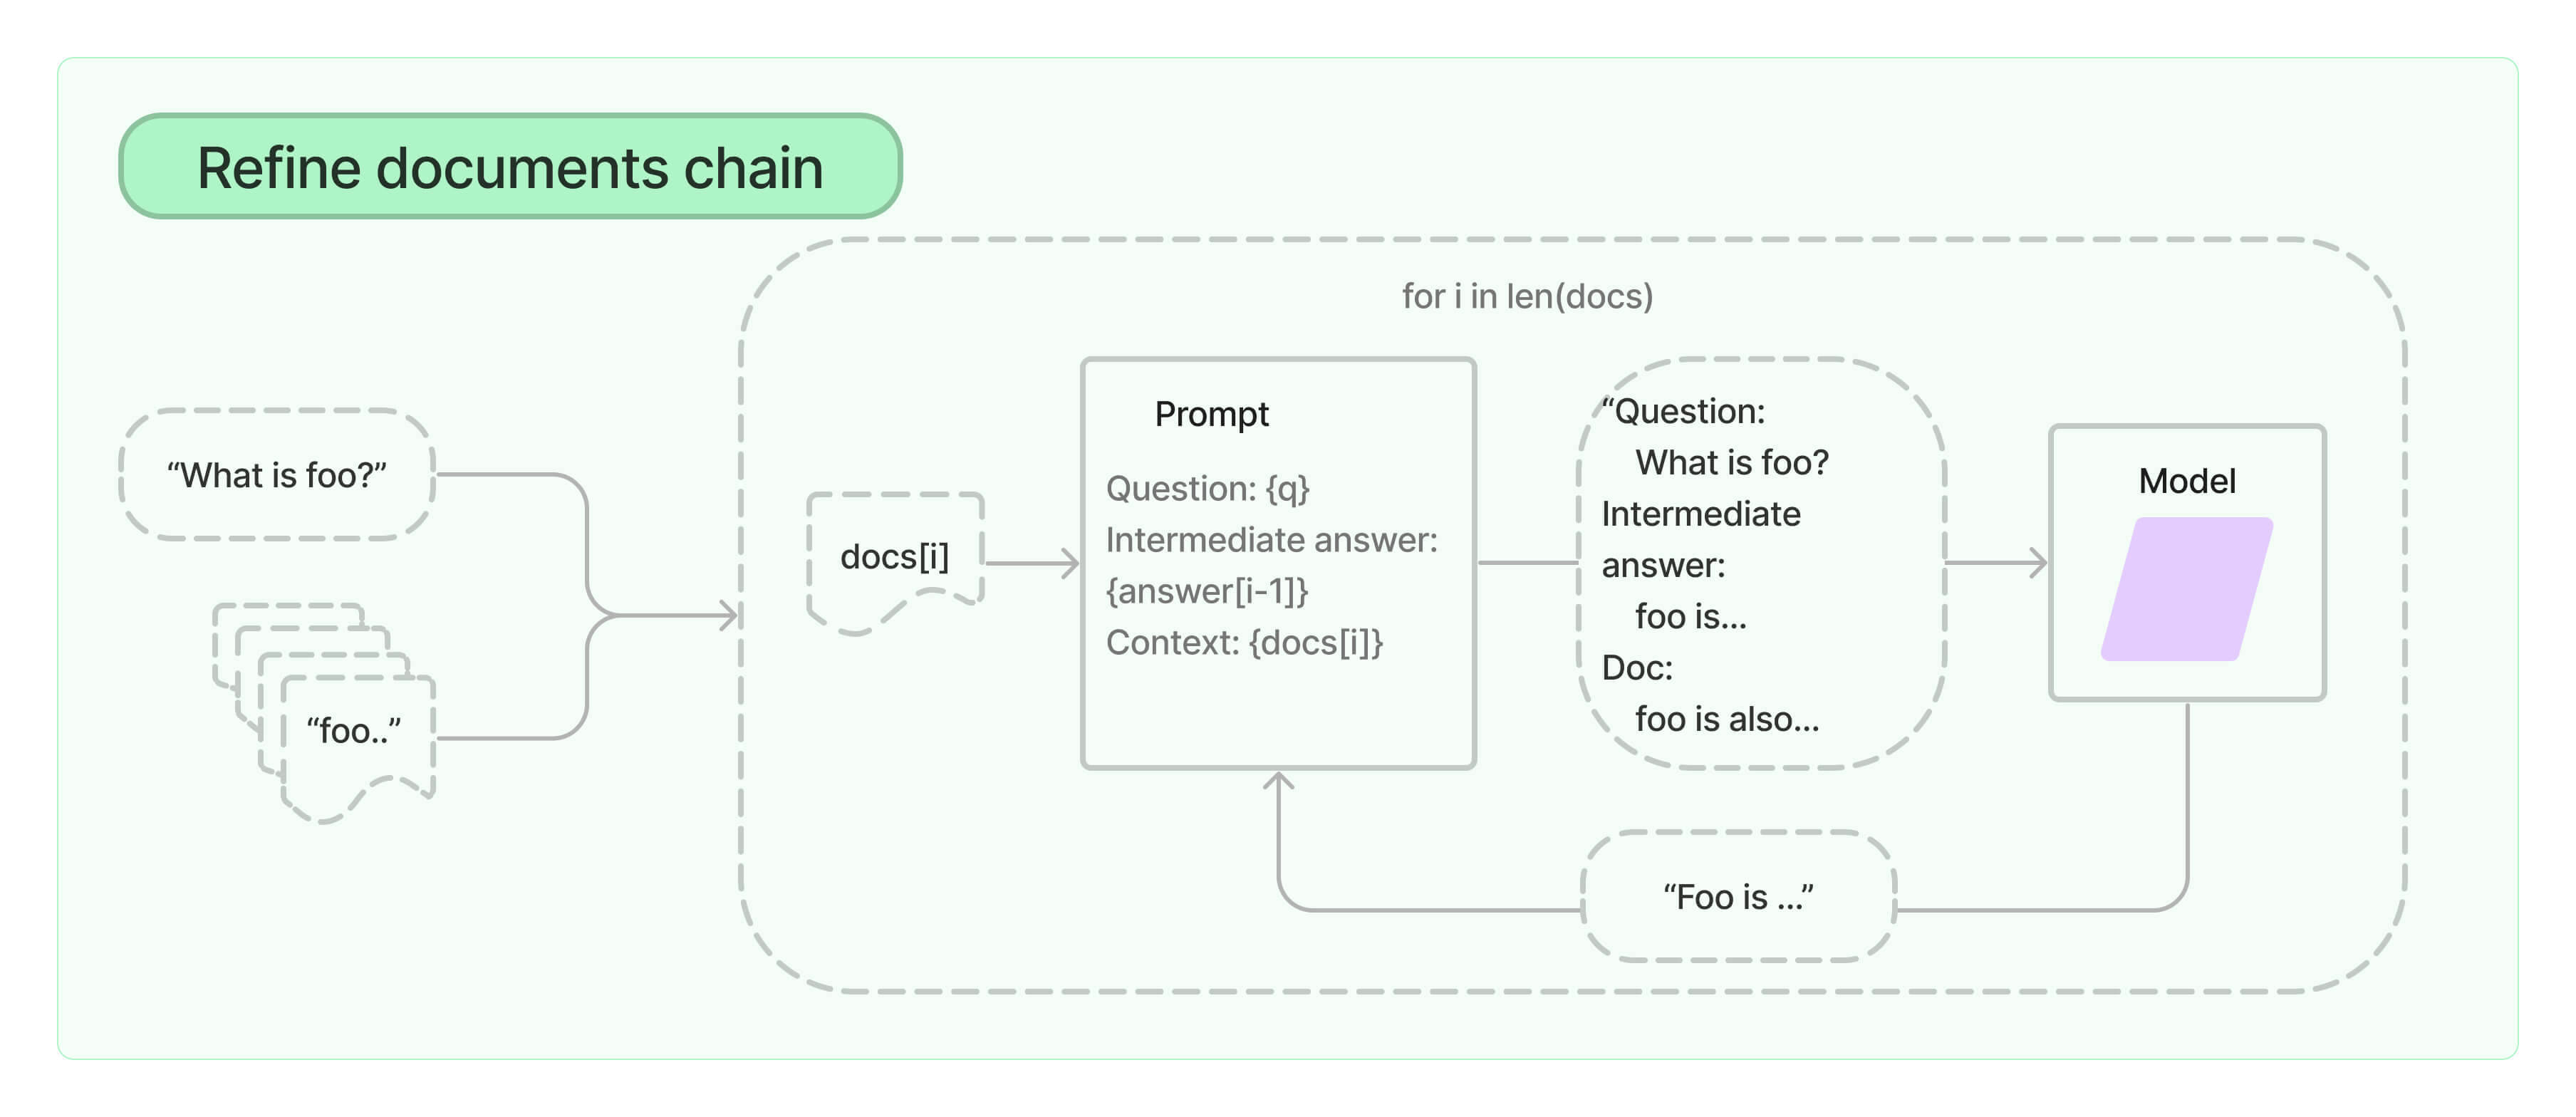

#### Legacy Refine

## Recreating with LCEL
With LangChain Expression Language we can easily recreate the RefineDocumentsChain, with the additional benefit of getting all the built-in LCEL features (batch, async, etc.) and with much more ability to customize specific parts of the chain.

In [ ]:
# Chain for generating initial summary based on the first document

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
partial_format_doc = partial(format_document, prompt=document_prompt)
summary_chain = {"context": partial_format_doc} | summarize_prompt | llm | StrOutputParser()

In [ ]:
# Chain for refining an existing summary based on
# an additional document

refine_prompt = PromptTemplate.from_template(
    "Here's your first summary: {prev_response}. "
    "Now add to it based on the following context: {context}"
)
refine_chain = (
    {
        "prev_response": itemgetter("prev_response"),
        "context": lambda x: partial_format_doc(x["doc"]),
    }
    | refine_prompt
    | llm
    | StrOutputParser()
)

In [ ]:
# The final refine loop, which generates an initial summary
# then iteratively refines it based on each of the rest of the documents


def refine_loop(docs):
    with trace_as_chain_group("refine loop", inputs={"input": docs}) as manager:
        summary = summary_chain.invoke(
            docs[0], config={"callbacks": manager, "run_name": "initial summary"}
        )
        for i, doc in enumerate(docs[1:]):
            summary = refine_chain.invoke(
                {"prev_response": summary, "doc": doc},
                config={"callbacks": manager, "run_name": f"refine {i}"},
            )
        manager.on_chain_end({"output": summary})
    return summary

## Refine Example run

In [ ]:
print(refine_loop(docs))

## Map re-rank
The map re-rank documents chain runs an initial prompt on each document, that not only tries to complete a task but also gives a score for how certain it is in its answer. The highest scoring response is returned.

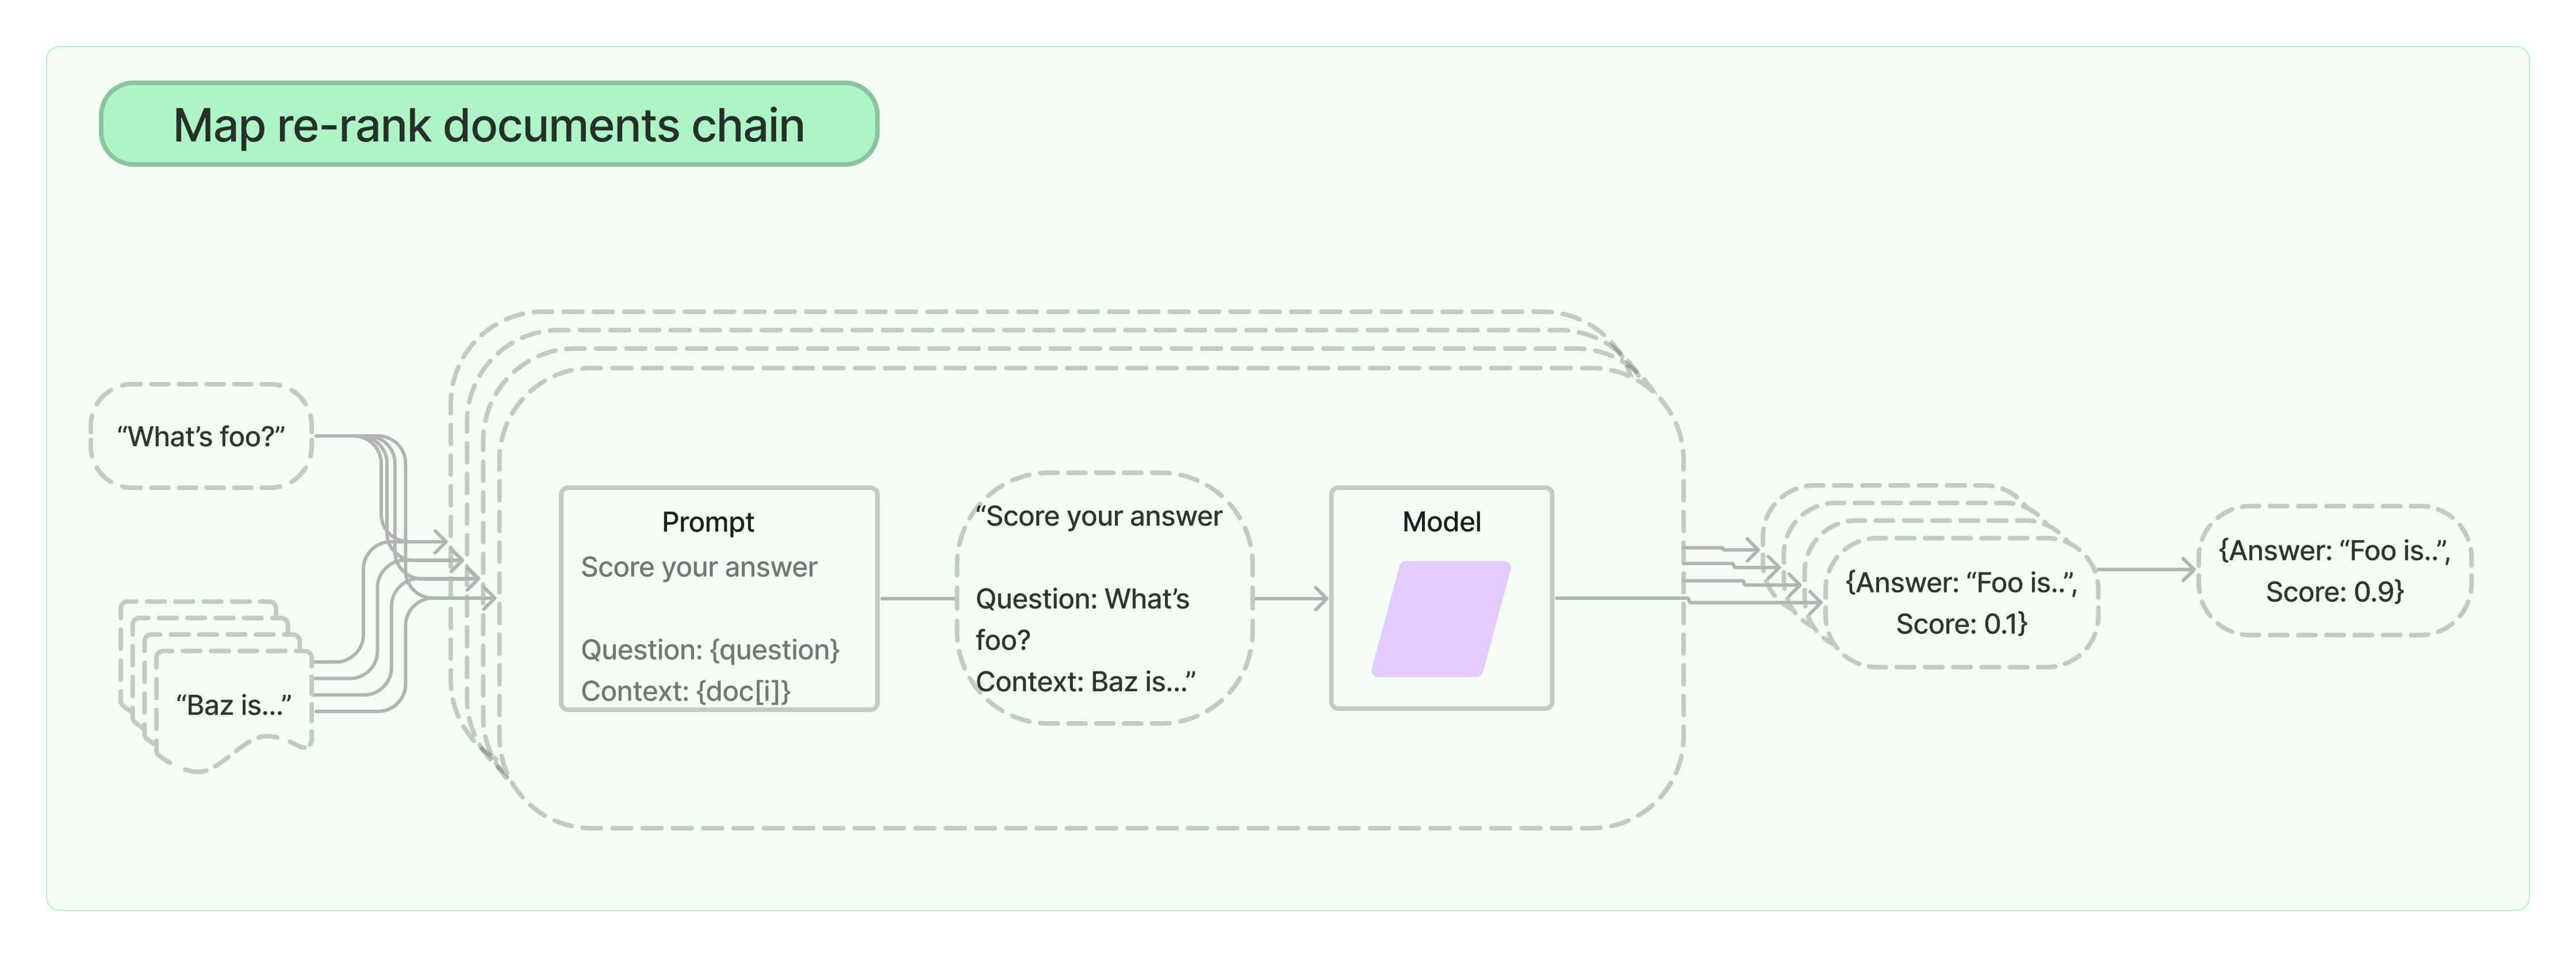

#### Legacy Map Rerank

In [ ]:
from langchain.output_parsers.openai_functions import PydanticOutputFunctionsParser
from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.utils.function_calling import convert_to_openai_function

In [ ]:
# Chain to apply to each individual document. Chain
# provides an answer to the question based on the document
# and scores it's confidence in the answer.

map_prompt = PromptTemplate.from_template(
    "Answer the user question using the context."
    "\n\nContext:\n\n{context}\n\nQuestion: {question}"
)


class AnswerAndScore(BaseModel):
    """Return the answer to the question and a relevance score."""

    answer: str = Field(
        description="The answer to the question, which is based ONLY on the provided context."
    )
    score: float = Field(
        decsription="A 0.0-1.0 relevance score, where 1.0 indicates the provided context answers the question completely and 0.0 indicates the provided context does not answer the question at all."
    )


function = convert_pydantic_to_openai_function(AnswerAndScore)
map_chain = (
    map_prompt
    | ChatOpenAI().bind(
        temperature=0, functions=[function], function_call={"name": "AnswerAndScore"}
    )
    | PydanticOutputFunctionsParser(pydantic_schema=AnswerAndScore)
).with_config(run_name="Map")

In [ ]:
# Final chain, which after answer and scoring based on
# each doc return the answer with the highest score.


def top_answer(scored_answers):
    return max(scored_answers, key=lambda x: x.score).answer


document_prompt = PromptTemplate.from_template("{page_content}")
map_rerank_chain = (
    (
        lambda x: [
            {
                "context": format_document(doc, document_prompt),
                "question": x["question"],
            }
            for doc in x["docs"]
        ]
    )
    | map_chain.map()
    | top_answer
).with_config(run_name="Map rerank")

In [ ]:
print(
    map_rerank_chain.invoke({"docs": docs, "question": "How were the vikings powered"})
)